In [1]:
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
from matplotlib_venn import venn3

%matplotlib inline

In [2]:
DATA_PATH = '../Data/'
df_max = pd.read_csv(DATA_PATH + 'clean_max.csv', index_col=0, parse_dates=[3])
df_mar = pd.read_csv(DATA_PATH + 'clean_mar.csv', index_col=0, parse_dates=[3])
df_sam = pd.read_csv(DATA_PATH + 'clean_sam.csv', index_col=0, parse_dates=[3])

df_all = [df_max, df_mar, df_sam]
df_sizes = [df.shape[0] for df in df_all]

### Assign Data Types 
int_columns = ['ID', 'Session', 'Receipt', 'Quantity', 'Basket']
string_columns = ['Item', 'ItemMore', 'Category', 'Comment']
for df in df_all:
    df.loc[:, int_columns] = df[int_columns].astype(int)
    df.loc[:, string_columns] = df[string_columns].astype(str)
    df.loc[:, 'Date'] = pd.to_datetime(df.Date, errors='coerce').dt.date

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2159 entries, 0 to 2158
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         2159 non-null   int32  
 1   Session    2159 non-null   int32  
 2   Receipt    2159 non-null   int32  
 3   Date       1718 non-null   object 
 4   Item       2159 non-null   object 
 5   ItemMore   2159 non-null   object 
 6   Uncertain  37 non-null     object 
 7   Unknown    87 non-null     object 
 8   Quantity   2159 non-null   int32  
 9   Hit        0 non-null      float64
 10  Miss       0 non-null      float64
 11  Category   2159 non-null   object 
 12  Comment    2159 non-null   object 
 13  Basket     2159 non-null   int32  
dtypes: float64(2), int32(5), object(7)
memory usage: 210.8+ KB


In [27]:
### Percent Receipt empty
for df in df_all:
    receipt_nonzero_count = df.Receipt.astype(bool).sum()
    null_percent = 1 - (receipt_nonzero_count / df.Receipt.shape[0])
    print(f'Receipt {null_percent:.0%} null')

Receipt 28% null
Receipt 50% null
Receipt 42% null


Intended shared IDs: {130, 153, 135, 137, 141, 114, 148, 121, 158, 127}
Actual shared IDs: {130, 153, 135, 137, 141, 114, 121, 127}


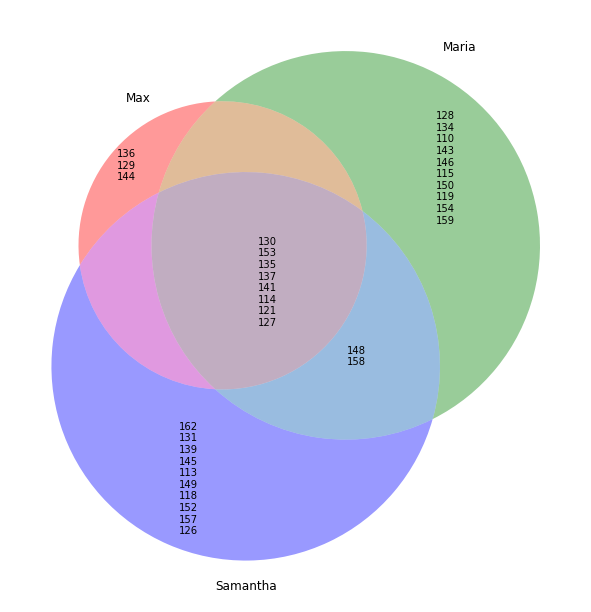

In [28]:
### Shared Participants
ids_max = set(df_max.ID.unique())
ids_mar = set(df_mar.ID.unique())
ids_sam = set(df_sam.ID.unique())
ids_shared = ids_max & ids_mar & ids_sam

ids_assigned_all = {121, 114, 137, 153, 141, 127, 130, 135, 148, 158}

print('Intended shared IDs:', ids_assigned_all)
print('Actual shared IDs:', ids_shared)

# Venn diagram
plt.figure(figsize=(11, 11))
v = venn3([ids_max, ids_mar, ids_sam], ('Max', 'Maria', 'Samantha'))

v.get_label_by_id('100').set_text('\n'.join(str(s) for s in (ids_max - ids_mar - ids_sam)))
v.get_label_by_id('110').set_text('\n'.join(str(s) for s in (ids_max & ids_mar - ids_sam)))
v.get_label_by_id('010').set_text('\n'.join(str(s) for s in (ids_mar - ids_max - ids_sam)))
v.get_label_by_id('101').set_text('\n'.join(str(s) for s in (ids_max & ids_sam - ids_mar)))
v.get_label_by_id('111').set_text('\n'.join(str(s) for s in (ids_shared)))
v.get_label_by_id('011').set_text('\n'.join(str(s) for s in (ids_mar & ids_sam - ids_max)))
v.get_label_by_id('001').set_text('\n'.join(str(s) for s in (ids_sam - ids_max - ids_mar)))

plt.savefig('../Output/id_venn_diagram.png')

df_shared = []
for df in df_all:
    df_shared.append(df[df.ID.isin(ids_shared)].copy())

In [29]:
### Expand Quantity
df_shared_expanded = []
for df in df_shared:
    df_expanded = pd.DataFrame(np.repeat(df.to_numpy(), df.Quantity, axis=0))
    df_expanded.columns = df.columns
    df_expanded.loc[:, 'Quantity'] = 1
    assert df.Quantity.sum() == df_expanded.shape[0]
    df_shared_expanded.append(df_expanded)

### Compare Shared Dimensions
# Expanding Quantity increases the variation
for pid in ids_shared:
    original_row_counts, expanded_row_counts = [], []
    for df_original, df_expanded in zip(df_shared, df_shared_expanded):
        original_row_counts.append(df_original[df_original.ID == pid].shape[0])
        expanded_row_counts.append(df_expanded[df_expanded.ID == pid].shape[0])
    print('Original', pid, original_row_counts,'StD =', np.std(original_row_counts, dtype=int))
    print('Expanded', pid, expanded_row_counts,'StD =', np.std(expanded_row_counts, dtype=int))

Original 130 [229, 297, 229] StD = 32
Expanded 130 [281, 355, 281] StD = 34
Original 153 [185, 186, 213] StD = 12
Expanded 153 [232, 225, 272] StD = 20
Original 135 [229, 229, 213] StD = 7
Expanded 135 [268, 262, 249] StD = 7
Original 137 [140, 139, 141] StD = 0
Expanded 137 [193, 189, 194] StD = 2
Original 141 [142, 120, 139] StD = 9
Expanded 141 [187, 141, 182] StD = 20
Original 114 [150, 151, 150] StD = 0
Expanded 114 [161, 160, 161] StD = 0
Original 121 [262, 257, 264] StD = 2
Expanded 121 [303, 296, 306] StD = 4
Original 127 [203, 194, 203] StD = 4
Expanded 127 [251, 242, 251] StD = 4


In [30]:
### Validate ID
ids_assigned_all = {121, 114, 137, 153, 141, 127, 130, 135, 148, 158}
ids_assigned_max = ids_assigned_all | {129, 136, 144, 147, 151, 
                                       156, 160, 112, 117, 120}
ids_assigned_mar = ids_assigned_all | {128, 134, 143, 146, 150, 
                                       154, 159, 110, 115, 119}
ids_assigned_sam = ids_assigned_all | {131, 139, 145, 149, 152, 
                                       157, 162, 113, 118, 126}

valid_ids = (ids_assigned_max | ids_assigned_mar | ids_assigned_sam)

assert all([df.ID.isin(valid_ids).all() for df in df_all])

id_diff_max = ids_assigned_max - set(df_max.ID.unique())
id_diff_mar = ids_assigned_mar - set(df_mar.ID.unique())
id_diff_sam = ids_assigned_sam - set(df_sam.ID.unique())

print("Max is missing IDs", id_diff_max)
print("Maria is missing IDs", id_diff_mar)
print("Samantha is missing IDs", id_diff_sam)
# TODO: Replace with assert empty

Max is missing IDs {160, 112, 147, 148, 117, 151, 120, 156, 158}
Maria is missing IDs set()
Samantha is missing IDs set()


In [ ]:
# TODO: explore evidence of systemic error
# Examine large baskets for multiple receipt error
""" Zero permutation baskets
PID=130: 7 3 1 1 4 2 16 6 1 14 5 8 0 0 0 0 0 0 0 0 0 
PID=153: 3 1 4 2 16 6 1 14 
PID=135: 3 1 1 4 2 16 6 1 14 5 8 0 0 0 0 0 0 
PID=137: 7 3 1 1 4 2 16 6 1 14 5 8 
PID=141: 7 3 1 1 4 2 16 6 
PID=114: 7 3 1 4 2 16 6 1 14 5 8 0 0 
PID=121: 7 3 1 1 4 2 16 6 1 14 5 8 0 0 0 0 0 0 0 
PID=127: 7 3 1 1 4 2 16 6 1 14 5 0 0 0 0 0 0 0 0 0 0 0 0 
"""